## Predicting price of medicines

<font size="4">Importing libraries</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import  tensorflow as tf

<font size="4">Reading data</font>

I used data from my another project "Analysis and vizualizations of Grodno pharmacies"

https://github.com/seblful/grodno_pharmacies_analysis

In [86]:
df = pd.read_csv('df_ph_04-12-22.csv')

Deleting unnecesary columns and columns with trade name for simplicity

In [87]:
target_rows = ['dosage_form', 'active_ingredient', 'is_prescribed', 'name_of_manufacturer',
              'country_of_manufaturer', 'is_import', 'retail_chain', 'price_of_medicine']

meds = df.loc[df.is_medicine == 1, target_rows].reset_index(drop=True)

<font size="4">Data analysis</font>

In [88]:
meds.head()

,dosage_form,active_ingredient,is_prescribed,name_of_manufacturer,country_of_manufaturer,is_import,retail_chain,price_of_medicine
0,таблетки 150мкг N100,Левотироксин натрия,0,Берлин-Хеми/Менарини,Германия,1,Inlek,9.28
1,порошок для приг. раствора внутр. 1г N20,Аскорбиновая кислота,0,Экзон,Беларусь,0,Inlek,3.60
2,таблетки 25мг N20,Аскорбиновая кислота,0,Белмедпрепараты,Беларусь,0,Inlek,0.76
3,таблетки покрытые оболочкой 100мг N20,Умифеновир,0,Лекфарм,Беларусь,0,Inlek,11.62
4,таблетки покрытые оболочкой N12,Парацетамол+Фенилэфрин+Хлорфенамин,0,Байер Консьюмер,Швейцария,1,Inlek,9.20


In [89]:
meds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327988 entries, 0 to 327987
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   dosage_form             327988 non-null  object 
 1   active_ingredient       327988 non-null  object 
 2   is_prescribed           327988 non-null  int64  
 3   name_of_manufacturer    327988 non-null  object 
 4   country_of_manufaturer  327988 non-null  object 
 5   is_import               327988 non-null  int64  
 6   retail_chain            327988 non-null  object 
 7   price_of_medicine       327988 non-null  float64
dtypes: float64(1), int64(2), object(5)
memory usage: 20.0+ MB


In [90]:
meds.describe().T

,count,mean,std,min,25%,50%,75%,max
is_prescribed,327988.0,0.145136,0.352239,0.00,0.00,0.00,0.0,1.00
is_import,327988.0,0.518766,0.499648,0.00,0.00,1.00,1.0,1.00
price_of_medicine,327988.0,16.104491,19.452182,0.06,5.82,11.14,20.1,1855.04


Finding outliers

[Text(0.5, 0, 'Price')]

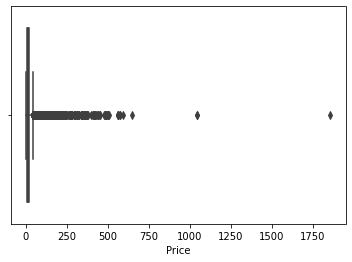

In [91]:
ax = sns.boxplot(meds.price_of_medicine)
ax.set(xlabel='Price')

Detect outliers with IQR

In [92]:
outliers=[]

def detect_outlier(arr):
    threshold=3
    mean = np.mean(arr)
    std =np.std(arr)
    
    for y in arr:
        z_score= (y - mean)/std 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

treshold_outliers = min(np.sort(detect_outlier(meds.price_of_medicine)))
print(f'Treshold outliers = {treshold_outliers}')

Treshold outliers = 74.48


[Text(0.5, 0, 'Price')]

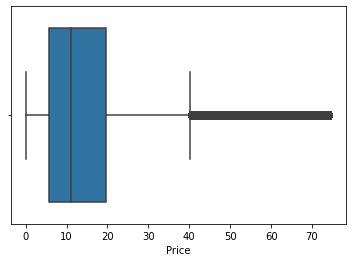

In [93]:
ax = sns.boxplot(meds.price_of_medicine[meds.price_of_medicine < treshold_outliers])
ax.set(xlabel='Price')

<font size="4">Data preprocessing</font>

Removing outliers

In [94]:
meds = meds.loc[meds.price_of_medicine < treshold_outliers]

Adding new column with categories of price

Text(0.5, 1.0, 'Price distribution')

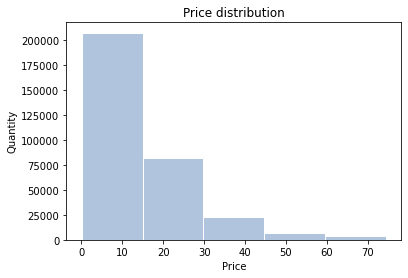

In [95]:
n, bins, patches = plt.hist(meds.price_of_medicine, bins=5, facecolor = 'lightsteelblue', edgecolor='white')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.title('Price distribution')

In [96]:
_, lowest_price_medicines, low_price_medicines, medium_price_medicines, high_price_medicines, highest_price_medicines = bins
print(*[i for i in bins][1:])

14.94 29.819999999999997 44.7 59.58 74.46


In [97]:
def cat_of_price(price):
    if high_price_medicines < price <= highest_price_medicines:
        return 'above_average'
    elif medium_price_medicines < price <= high_price_medicines:
        return 'average'
    elif low_price_medicines < price <= medium_price_medicines:
        return 'below_average'
    elif lowest_price_medicines < price <= low_price_medicines:
        return 'low'
    elif price <= lowest_price_medicines:
        return 'lowest'
    else:
        return 'what'

In [98]:
meds['category_of_price'] = meds.price_of_medicine.apply(cat_of_price)
meds.category_of_price.unique()

array(['lowest', 'low', 'below_average', 'average', 'above_average'],
      dtype=object)

Making simpler dosage form

In [99]:
meds.dosage_form = meds.dosage_form.apply(lambda x: x.split()[0])

One-hot encoding

In [100]:
categorical_cols = ['category_of_price', 'dosage_form', 'active_ingredient', 'name_of_manufacturer', 'country_of_manufaturer', 'retail_chain'] 

meds = pd.get_dummies(meds, columns = categorical_cols)

meds.head()

,is_prescribed,is_import,price_of_medicine,category_of_price_above_average,category_of_price_average,category_of_price_below_average,category_of_price_low,category_of_price_lowest,dosage_form_аэрозоль,dosage_form_бальзам,...,retail_chain_Ивафарм,retail_chain_Искамед,retail_chain_Лигматон,retail_chain_Мелисса,retail_chain_Моя Аптека,retail_chain_Остров здоровья,retail_chain_Планета Здоровья,retail_chain_Ремедика,retail_chain_Салюслайн,retail_chain_ФармОстров
0,0,1,9.28,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3.60,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.76,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,11.62,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,9.20,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Changing name of columns

In [101]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

meds.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in meds.columns.values]

<font size="4">Models building</font>

In [102]:
X = meds.loc[:, meds.columns != 'price_of_medicine']
y = meds.loc[:, 'price_of_medicine']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [20]:
pipeline_lr = Pipeline([("lr", LinearRegression())])
pipeline_lasso = Pipeline([("lasso", Lasso())])
pipeline_ridge = Pipeline([("ridge", Ridge())])
pipeline_elastic = Pipeline([("elastik", ElasticNet())])
pipeline_tree = Pipeline([("tree", DecisionTreeRegressor())])
pipeline_r_trees = Pipeline([("r_trees", RandomForestRegressor())])
pipeline_k_neighb = Pipeline([("k_neighb", KNeighborsRegressor())])
pipeline_xgb = Pipeline([("xgb", XGBRegressor())])

In [21]:
pipelines = [pipeline_lr, pipeline_lasso, pipeline_ridge, pipeline_elastic, pipeline_tree, 
             pipeline_r_trees, pipeline_k_neighb, pipeline_xgb]

pipeline_dict = {0: "LinearRegression", 1: "Lasso", 2: "Ridge", 3: "ElasticNet", 4: "DecisionTreeRegressor", 
                 5: "RandomForestRegressor", 6: "KNeighborsRegressor", 7: "XGBRegressor"}

<font size="4">Models evaluation</font>

In [22]:
for n, pipe in enumerate(pipelines):
    pipe.fit(X_train, y_train)
    print(f'{n+1}. {pipeline_dict[n]}() has finished')

1. LinearRegression() has finished
2. Lasso() has finished
3. Ridge() has finished
4. ElasticNet() has finished
5. DecisionTreeRegressor() has finished
6. RandomForestRegressor() has finished
7. KNeighborsRegressor() has finished
8. XGBRegressor() has finished


In [ ]:
mse_scores = []
r2_scores = []
for i, model in enumerate(pipelines):
    y_pred_temp = model.predict(X_test)
    mse_temp = mean_squared_error(y_test, y_pred_temp)
    r2_temp = r2_score(y_test, y_pred_temp)
    mse_scores.append(mse_temp)
    r2_scores.append(r2_temp)

In [115]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [116]:
df_scores_m = pd.DataFrame({'MSE': mse_scores, 'R2':r2_scores}, index=pipeline_dict.values())
df_scores_m

,MSE,R2
LinearRegression,200459345972419744.000,-1330492335152505.750
Lasso,63.976,0.575
Ridge,7.548,0.950
ElasticNet,95.586,0.366
DecisionTreeRegressor,3.854,0.974
RandomForestRegressor,3.635,0.976
KNeighborsRegressor,4.666,0.969
XGBRegressor,7.506,0.950


<font size="4">Building the ANN</font>

In [45]:
lnn = tf.keras.models.Sequential()
lnn.add(tf.keras.layers.Dense(units=32, activation='relu'))
lnn.add(tf.keras.layers.Dense(units=16, activation='relu'))
lnn.add(tf.keras.layers.Dense(units=8, activation='relu'))
lnn.add(tf.keras.layers.Dense(units=1))

In [46]:
lnn.compile(loss='mean_absolute_error', optimizer='adam', 
            metrics = [tf.keras.metrics.MeanSquaredError()])

In [47]:
lnn.fit(X_train, y_train, batch_size = 32, epochs=50)

Epoch 1/50
6761/6761 [==============================] - 21s 3ms/step - loss: 2.1564 - mean_squared_error: 15.1980
Epoch 2/50
6761/6761 [==============================] - 21s 3ms/step - loss: 1.5453 - mean_squared_error: 5.4655
Epoch 3/50
6761/6761 [==============================] - 24s 4ms/step - loss: 1.4658 - mean_squared_error: 5.0674
Epoch 4/50
6761/6761 [==============================] - 22s 3ms/step - loss: 1.4227 - mean_squared_error: 4.8730
Epoch 5/50
6761/6761 [==============================] - 21s 3ms/step - loss: 1.3928 - mean_squared_error: 4.7360
Epoch 6/50
6761/6761 [==============================] - 19s 3ms/step - loss: 1.3707 - mean_squared_error: 4.6444
Epoch 7/50
6761/6761 [==============================] - 21s 3ms/step - loss: 1.3552 - mean_squared_error: 4.5958
Epoch 8/50
6761/6761 [==============================] - 21s 3ms/step - loss: 1.3424 - mean_squared_error: 4.5353
Epoch 9/50
6761/6761 [==============================] - 19s 3ms/step - loss: 1.3297 - mean_squa

<font size="4">ANN model evaluation</font>

In [66]:
y_pred_nn = lnn.predict(X_test)

3330/3330 [==============================] - 8s 2ms/step


In [76]:
mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)

In [117]:
df_scores_nn = pd.DataFrame({'MSE': mse_nn, 'R2':r2_nn}, index=['ANN'])
df_scores_nn

,MSE,R2
ANN,4.272,0.972


<font size="4">Final rating</font>

In [118]:
df_scores = pd.concat([df_scores_m, df_scores_nn]).sort_values('MSE', ascending=True)
df_scores

,MSE,R2
RandomForestRegressor,3.635,0.976
DecisionTreeRegressor,3.854,0.974
ANN,4.272,0.972
KNeighborsRegressor,4.666,0.969
XGBRegressor,7.506,0.950
Ridge,7.548,0.950
Lasso,63.976,0.575
ElasticNet,95.586,0.366
LinearRegression,200459345972419744.000,-1330492335152505.750


The Linear Regression without regularization is the worst model with the highest mean squared error. 

The best choice of type of regularization for linear regression is Ridge regularization.

Random Forest Regression has the lowest mean squared error and highest R2 metric, what makes this model best.

Oher ensemble methods also show good results. XGB Regressor can show better results with correct hyperparameters.

Artificial neural network has good metrics and can also be better with correct architecture and longer training.